# Question Answering


##### run "pip install -r requirements.txt"


# Setup


In [2]:
from langchain.vectorstores.cassandra import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings

from datasets import load_dataset  # support for dataset retrieval with Hugging Face
import os
import cassio  # to integrate with Astra DB
from PyPDF2 import PdfReader

/home/mojo/anaconda3/envs/tf-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ASTRA_DB_APPLICATION_TOKEN = os.environ["ASTRA_DB_APPLICATION_TOKEN"]
ASTRA_DB_ID = os.environ["ASTRA_DB_ID"]

In [4]:
pdfreader = PdfReader("./data.pdf")

In [5]:
from typing_extensions import Concatenate

# read text from pdf
raw_text = ""
for i, page in enumerate(pdfreader.pages):
    content = page.extract_text()
    if content:
        raw_text += content

raw_text

' \nData science is an interdisciplinary academic ﬁeld[1] that uses statistics, scientiﬁc computing, \nscientiﬁc methods, processing, scientiﬁc visualization, algorithms and systems to extract or \nextrapolate knowledge and insights from potentially noisy, structured, or unstructured data.[2]  \n \nData science also integrates domain knowledge from the underlying application domain (e.g., \nnatural sciences, information technology, and medicine).[3]  \nData science is multifaceted and can be described as a science, a research paradigm, a research \nmethod, a discipline, a workﬂow, and a profession.[4]  \n \nData science is "a concept to unify statistics, data analysis, informatics, and their related methods" \nto "understand and analyze actual phenomena"  \nwith data.[5] It uses techniques and theories drawn from many ﬁelds within the context of \nmathematics, statistics, computer science, information science,  \nand domain knowledge.[6] However, data science is different from computer

In [6]:
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

### Create the langchain embedding and LLM objects : - these embeddings are needed for the model to understand the text


# Testing embedding


In [16]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
import os

import getpass

env_path = "../.env"
load_dotenv(dotenv_path=env_path)


# if not os.getenv("GOOGLE_API_KEY"):
#     os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API key: ")


GOOGLE_GENAI_KEY = os.environ.get("GOOGLE_GENAI_KEY")

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-exp-03-07",
    google_api_key=GOOGLE_GENAI_KEY,
)
vector = embeddings.embed_query("hello, world!")
vector[:5]

[-0.022807613015174866,
 0.010274127125740051,
 0.011706576682627201,
 -0.09699729084968567,
 -0.0027657211758196354]

In [20]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import GoogleGenerativeAI

import os

llm = GoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=GOOGLE_GENAI_KEY)
embedding = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-exp-03-07", key=GOOGLE_GENAI_KEY
)
# print(
#     llm.invoke(
#         "What are some of the pros and cons of Python as a programming language?"
#     )
# )
len(embedding.embed_query("hello, world!")), embedding.embed_query("hello, world!")

(3072,
 [-0.022807613015174866,
  0.010274127125740051,
  0.011706576682627201,
  -0.09699729084968567,
  -0.0027657211758196354,
  0.015305615961551666,
  -0.011274486780166626,
  -0.007876780815422535,
  0.02033296599984169,
  0.0026900325901806355,
  -0.00824178010225296,
  -0.011850079521536827,
  -0.00084327207878232,
  0.011589258909225464,
  0.16473577916622162,
  -0.003593549132347107,
  0.0008366623078472912,
  -0.00028645992279052734,
  0.003667632583528757,
  -0.013738134875893593,
  0.0069414894096553326,
  0.0005680338363163173,
  0.015419352799654007,
  -0.0016907735262066126,
  -0.014117076992988586,
  -0.004591678269207478,
  0.019385715946555138,
  -0.005694519262760878,
  0.01465996541082859,
  0.00257467501796782,
  0.00446938956156373,
  0.015604333020746708,
  -0.007003793492913246,
  0.007002117577940226,
  -0.005960177630186081,
  0.018425678834319115,
  0.020136645063757896,
  0.005117754451930523,
  -0.0008191515225917101,
  0.0026424650568515062,
  -0.00579354

### Langchain vector store: - to store the document


In [9]:
astra_vector_store = Cassandra(
    embedding=embedding,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None,
)

In [10]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    separator="\n",
    chunk_size=800,
    chunk_overlap=10,
    length_function=len,
)

texts = text_splitter.split_text(raw_text)
texts[:5]

['Data science is an interdisciplinary academic ﬁeld[1] that uses statistics, scientiﬁc computing, \nscientiﬁc methods, processing, scientiﬁc visualization, algorithms and systems to extract or \nextrapolate knowledge and insights from potentially noisy, structured, or unstructured data.[2]  \n \nData science also integrates domain knowledge from the underlying application domain (e.g., \nnatural sciences, information technology, and medicine).[3]  \nData science is multifaceted and can be described as a science, a research paradigm, a research \nmethod, a discipline, a workﬂow, and a profession.[4]  \n \nData science is "a concept to unify statistics, data analysis, informatics, and their related methods" \nto "understand and analyze actual phenomena"',
 'with data.[5] It uses techniques and theories drawn from many ﬁelds within the context of \nmathematics, statistics, computer science, information science,  \nand domain knowledge.[6] However, data science is different from computer 

In [12]:
astra_vector_store.add_texts(texts)
print("Inserted %i headlines." % len(texts))
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 5 headlines.


# Run the QA cycle


In [13]:
first_question = True

while True:
    if first_question:
        query_text = input("\nEnter your question (or type 'quit' to exit): ").strip()
    else:
        query_text = input(
            "\nWhat is your next question? (or type 'quit' to exit): "
        ).strip()

    if query_text.lower() == "quit":
        break

    if query_text == "":
        continue

    first_question = False

    print('\nQUESTION: "%s"' % query_text)
    answer = astra_vector_index.query(query_text, llm=llm).strip()
    print('ANSWER: \%s ..."\n' % answer)

    print("FIRST DOCUMENT BY RELEVANCE: ")
    for doc, score in astra_vector_store.similarity_search_with_score(query_text, k=4):
        print('     [%0.4f] "%s .."' % (score, doc.page_content[:84]))


QUESTION: "what is data science"
ANSWER: \Data science is an interdisciplinary field focused on extracting knowledge from large datasets and applying that knowledge to solve problems in various application domains.  It involves preparing data for analysis, formulating problems, analyzing data, developing data-driven solutions, and presenting findings to inform high-level decisions.  The field incorporates skills from computer science, statistics, information science, mathematics, and various visualization techniques. ..."

FIRST DOCUMENT BY RELEVANCE: 
     [0.8548] "for a lot less money and in a lot less time. Smaller firms now have simpler
access t .."
     [0.8548] "for a lot less money and in a lot less time. Smaller firms now have simpler
access t .."
     [0.8543] "Data science is an interdisciplinary ﬁeld[10] focused on extracting knowledge from t .."
     [0.8543] "Data science is an interdisciplinary ﬁeld[10] focused on extracting knowledge from t .."


# Experimental


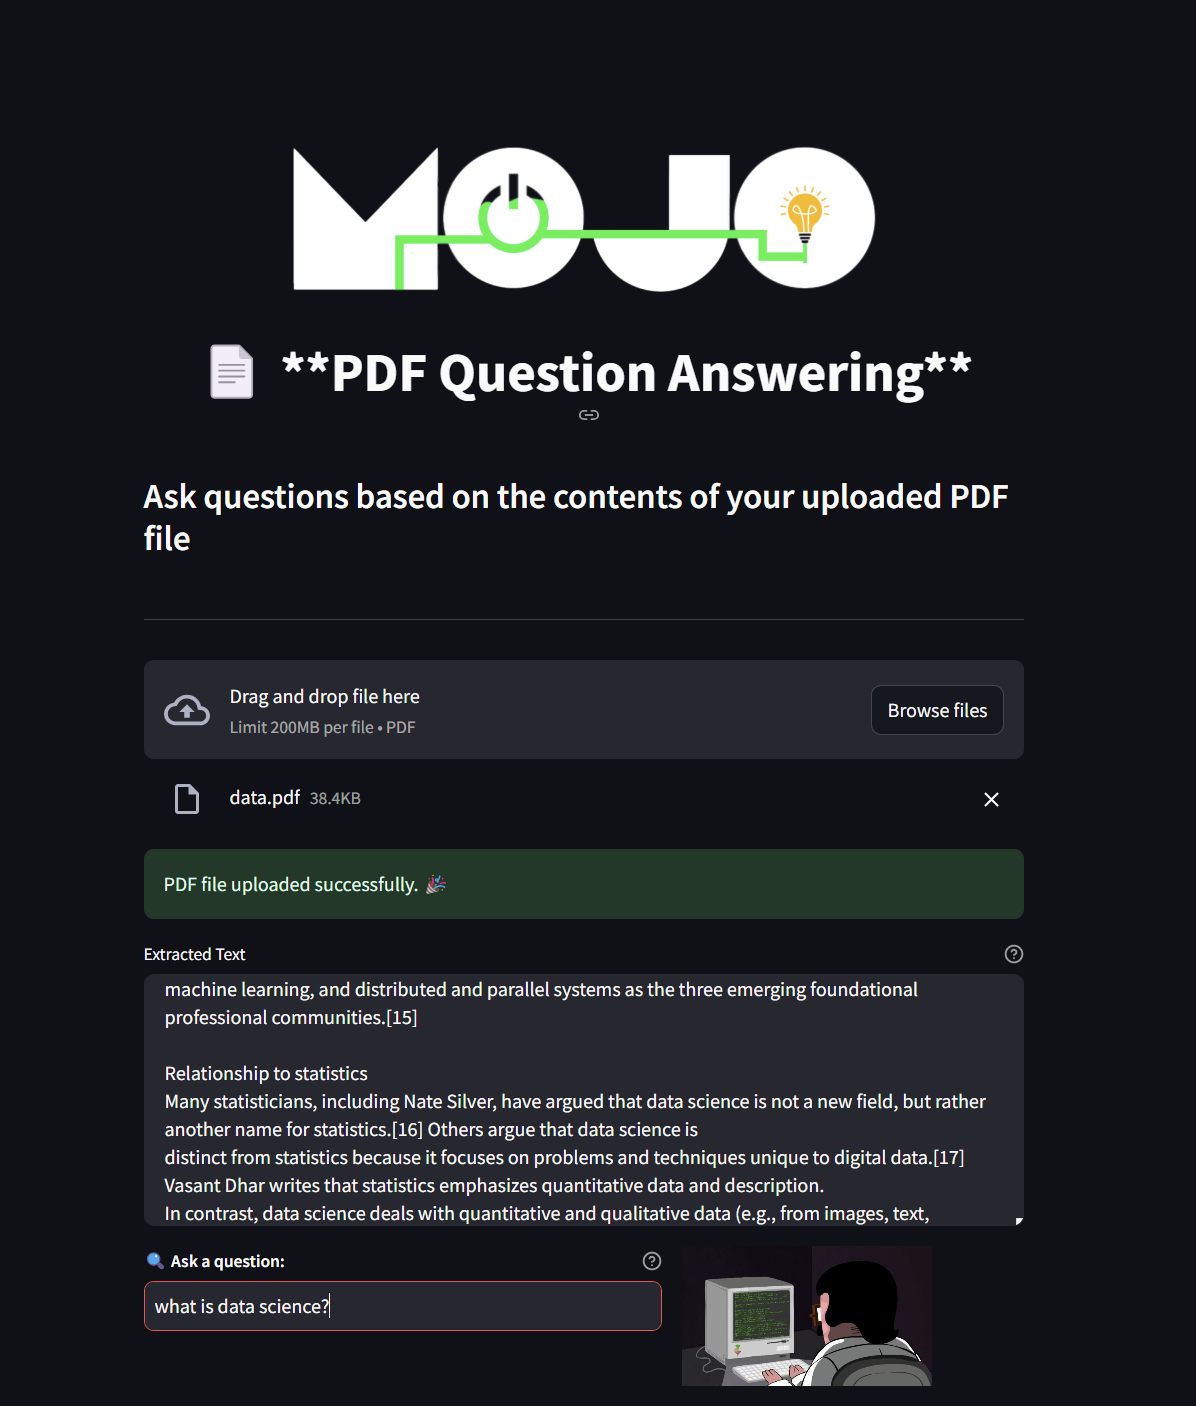
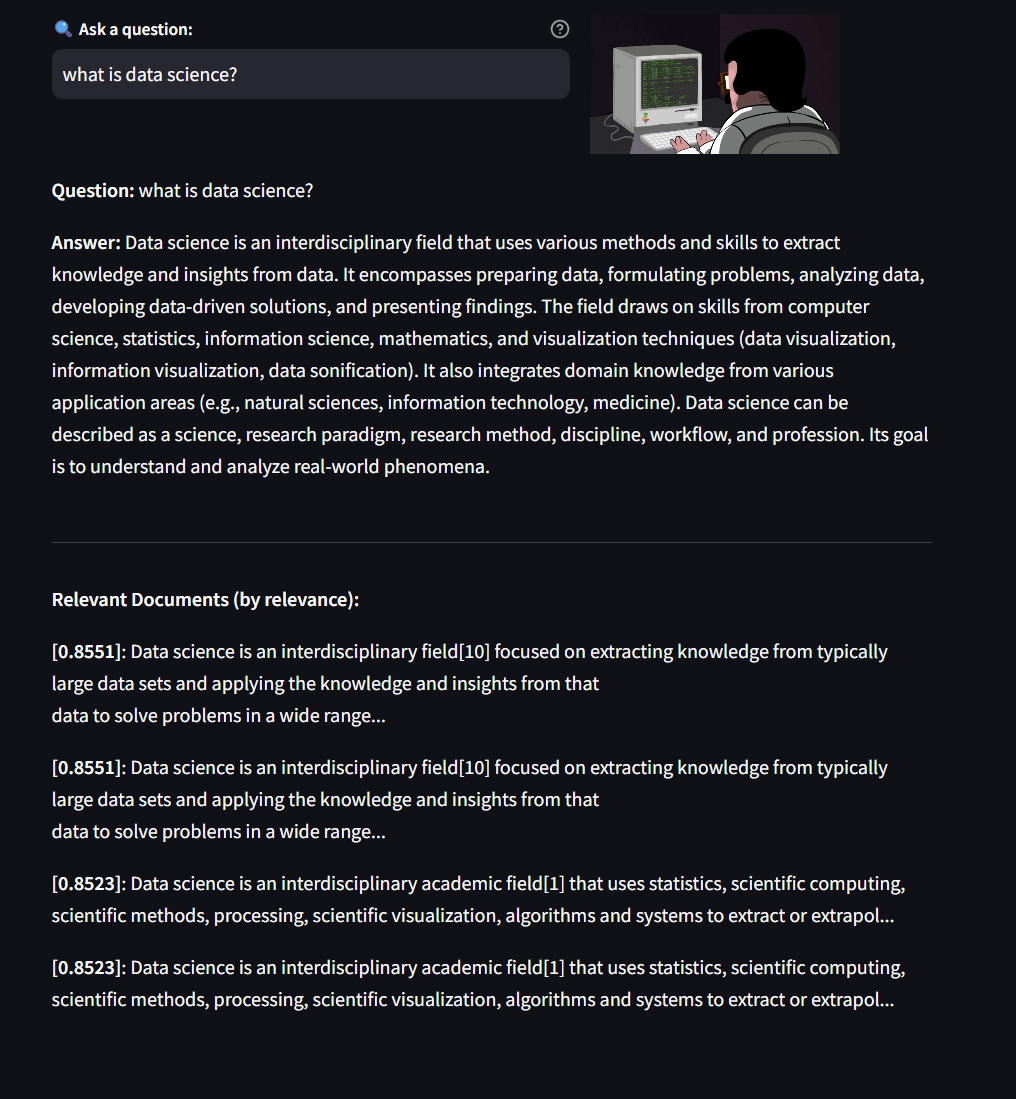
